#Prototypical Netwoks on the Omniglot dataset

You can save a copy to your Drive before executing this notebook



*   `Author:` Shreyas B
*   `Date:` 07/2023


##Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import data

The Omniglot dataset is taken on [the official GitHub repository](https://github.com/brendenlake/omniglot)

##Read data

In [14]:
def read_plants(plant_directory_path,plant_directory_name ):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    # plants = os.listdir(plant_directory_path)
    print(plant_directory_path)
    # for p in plants:
    #   print(plant_directory_path+'/'+p)
    images = os.listdir(plant_directory_path)
    print(images)
    for img in images:
        image = cv2.resize(
                 cv2.imread
                   (plant_directory_path +'/' + img),
                   (64,64)
                 )

        datax.append(image)
        datay.append(
                plant_directory_name
            )
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_plants,
                          args=(
                              base_directory+'/'+directory,directory
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [39]:
# plant_directory_path='drive/MyDrive/TEST'
# plants = os.listdir(plant_directory_path)
# images = os.listdir(plant_directory_path +'/'+ plants[0])
# print(images)
# for img in images:
#    image = cv2.resize(
#                  cv2.imread
#                    (plant_directory_path + '/'+ plants[0] + '/' + img),
#                    (28,28)
#                  )


['image (449).JPG', 'image (388).JPG', 'image (330).JPG', 'image (367).JPG', 'image (222).JPG', 'image (275).JPG', 'image (408).JPG', 'image (234).JPG', 'image (263).JPG', 'image (371).JPG', 'image (326).JPG', 'image (598).JPG', 'image (259).JPG', 'image (577).JPG', 'image (432).JPG', 'image (609).JPG', 'image (127).JPG', 'image (465).JPG', 'image (71).JPG', 'image (26).JPG', 'image (429).JPG', 'image (215).JPG', 'image (583).JPG', 'image (350).JPG', 'image (351).JPG', 'image (214).JPG', 'image (428).JPG', 'image (84).JPG', 'image (582).JPG', 'image (306).JPG', 'image (243).JPG', 'image (613).JPG', 'image (605).JPG', 'image (490).JPG', 'image (185).JPG', 'image (310).JPG', 'image (193).JPG', 'image (486).JPG', 'image (255).JPG', 'image (9).JPG', 'image (594).JPG', 'image (469).JPG', 'image (92).JPG', 'image (445).JPG', 'image (279).JPG', 'image (500).JPG', 'image (347).JPG', 'image (202).JPG', 'image (296).JPG', 'image (150).JPG', 'image (238).JPG', 'image (51).JPG', 'image (107).JPG',

In [15]:
%%time
trainx, trainy = read_images('drive/MyDrive/TRAIN')

drive/MyDrive/TRAIN/Corn___Common_rust
['image (941).JPG', 'image (293).JPG', 'image (199).JPG', 'image (1044).JPG', 'image (856).JPG', 'image (698).JPG', 'image (1046).JPG', 'image (886).JPG', 'image (103).JPG', 'image (135).JPG', 'image (5).JPG', 'image (1192).JPG', 'image (670).JPG', 'image (603).JPG', 'image (660).JPG', 'image (824).JPG', 'image (67).JPG', 'image (81).JPG', 'image (133).JPG', 'image (268).JPG', 'image (852).JPG', 'image (595).JPG', 'image (937).JPG', 'image (908).JPG', 'image (230).JPG', 'image (839).JPG', 'image (1100).JPG', 'image (322).JPG', 'image (64).JPG', 'image (1146).JPG', 'image (41).JPG', 'image (229).JPG', 'image (139).JPG', 'image (952).JPG', 'image (861).JPG', 'image (737).JPG', 'image (221).JPG', 'image (241).JPG', 'image (184).JPG', 'image (830).JPG', 'image (648).JPG', 'image (66).JPG', 'image (1172).JPG', 'image (1015).JPG', 'image (1089).JPG', 'image (1136).JPG', 'image (1106).JPG', 'image (237).JPG', 'image (610).JPG', 'image (1131).JPG', 'image

In [16]:
trainx.shape

(16611, 64, 64, 3)

In [8]:
%%time
testx, testy = read_images('drive/MyDrive/TRAIN')

CPU times: user 618 ms, sys: 477 ms, total: 1.1 s
Wall time: 26.1 s


In [9]:
trainx.shape, trainy.shape

((16611, 32, 32, 3), (16611,))

The training set contains 77,120 images (from 964 * 4 = 3,856 characters in images_background) and the testing set contains 52,720 images (from 659 * 4 = 2,636 characters in images_evaluation).

##Create samples

In [17]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [27]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




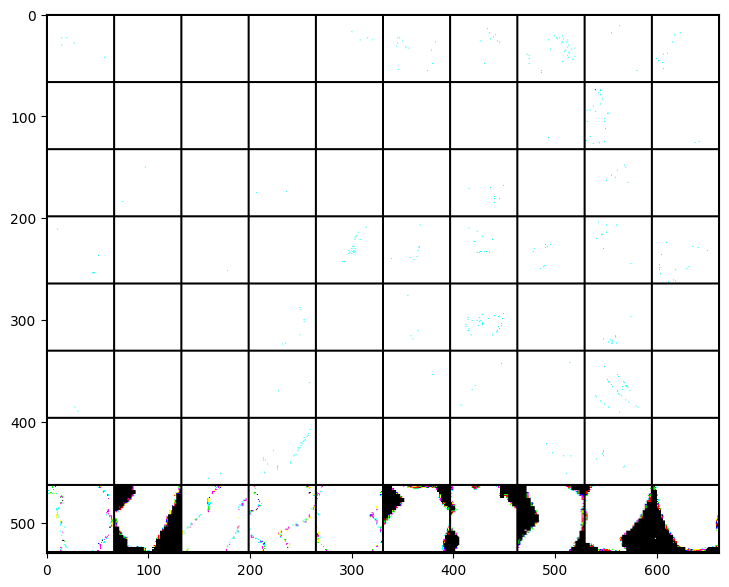

In [28]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [20]:
sample_example['images'].shape

torch.Size([8, 10, 3, 64, 64])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The embedding part takes a (28x28x3) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer.

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [29]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )

  return ProtoNet(encoder)

In [30]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]

    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()

    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)

    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [31]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [32]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [33]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [37]:
%%time

model = load_protonet_conv(
    x_dim=(3,64,64),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

<ipython-input-33-cba23b1f7c8d>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.6365 Acc: 0.9405


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0707 Acc: 0.9767


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0480 Acc: 0.9833


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0250 Acc: 0.9914


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0166 Acc: 0.9943
CPU times: user 6min 12s, sys: 1min 5s, total: 7min 17s
Wall time: 7min 22s


In [46]:
from PIL import Image
data = Image.fromarray(train_x[0])

    # saving the final output
    # as a PNG file
data.save('gfg_dummy_pic.png')

##Test

In [20]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [21]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

<ipython-input-20-5c259eed931d>:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0237 Acc: 0.9959


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

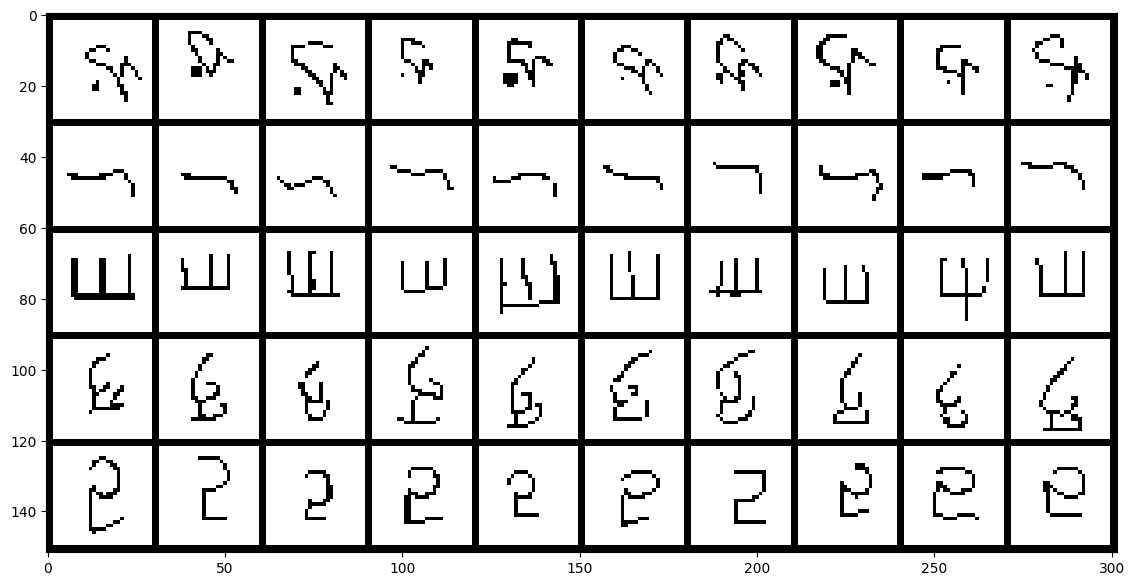

In [22]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [23]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [24]:
my_output

{'loss': 4.76837103136063e-09,
 'acc': 1.0,
 'y_hat': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}

In [25]:
base_directory = 'images_background'
for directory in os.listdir(base_directory):
        print(base_directory + '/' + directory + '/', directory)

images_background/Futurama/ Futurama
images_background/Japanese_(katakana)/ Japanese_(katakana)
images_background/N_Ko/ N_Ko
images_background/Inuktitut_(Canadian_Aboriginal_Syllabics)/ Inuktitut_(Canadian_Aboriginal_Syllabics)
images_background/Asomtavruli_(Georgian)/ Asomtavruli_(Georgian)
images_background/Balinese/ Balinese
images_background/Braille/ Braille
images_background/Bengali/ Bengali
images_background/Japanese_(hiragana)/ Japanese_(hiragana)
images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/ Ojibwe_(Canadian_Aboriginal_Syllabics)
images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/ Blackfoot_(Canadian_Aboriginal_Syllabics)
images_background/Arcadian/ Arcadian
images_background/Sanskrit/ Sanskrit
images_background/Gujarati/ Gujarati
images_background/Grantha/ Grantha
images_background/Armenian/ Armenian
images_background/Hebrew/ Hebrew
images_background/Tifinagh/ Tifinagh
images_background/Burmese_(Myanmar)/ Burmese_(Myanmar)
images_background/Syriac_(Estrang